#                                     Life Expectancy Dataset Analysis

This dataset consists of data for 183 countries from 2000 to 2015  mainly focusing on development status information, immunization, mortality, social, and economic aspects of countries. In this project, we will test if adult mortality 
and life expectancy have a significant difference between the years of 2006-2010 and 2011-2015. A portion of data , data from 2006 to 2015 and developing countries, have been taken from the total dataset and used in this analysis. Let us dive into the process...


In [ ]:
# All libraries related with statistics and plot are imported here
import pandas as pd
import numpy as np

from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.graphics.gofplots import qqplot

import seaborn as sns
import matplotlib.pyplot as plt


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# A function that calculate a 95% CI for 2 1d numpy arrays for two variables that satisfy normality

def get_95_ci_p(x1, x2):

    signal = x1.mean() - x2.mean()
    noise = np.sqrt(x1.var() / x1.size + x2.var() / x2.size)

    ci_lo = signal - 1.96 * noise
    ci_hi = signal + 1.96 * noise

    return ci_lo, ci_hi

In [ ]:
# read in data and know some information about it
data_url= 'https://docs.google.com/spreadsheets/d/1eQL6gfa5O_wwaJUe482Cv093dP-fyezGHxfnCnp7ye4/export?format=csv'
df=pd.read_csv(data_url)
# df=pd.read_csv('\pro_data\Life Expectancy Data.csv')
df.info()
df.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Country                          2938 non-null   object 
 1   Year                             2938 non-null   int64  
 2   Status                           2938 non-null   object 
 3   Life expectancy                  2928 non-null   float64
 4   Adult Mortality                  2928 non-null   float64
 5   infant deaths                    2938 non-null   int64  
 6   Alcohol                          2744 non-null   float64
 7   percentage expenditure           2938 non-null   float64
 8   Hepatitis B                      2385 non-null   float64
 9   Measles                          2938 non-null   int64  
 10  BMI                              2904 non-null   float64
 11  under-five deaths                2938 non-null   int64  
 12  Polio               

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,19.1,83,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,18.6,86,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,18.1,89,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9


In [ ]:
# Continue examaning our data - size (no of rows and columns) and liist of columns
print(df.shape)
df.columns

In [ ]:
# Rename column names for the purpuse of consistency and ease of use- remove spaces and replace them with under score
# Change all column names to lower case
cols = list(df.columns)
upd_cols = []
for col in cols:
    upd_cols.append(col.strip().replace('  ', ' ').replace(' ', '_').lower())
df.columns = upd_cols

In [ ]:
# Display summary information regarding missing values
df.isna().sum()

In [ ]:
# Drop rows that contain missing values for the specifc variables participating in the analysis
# In the real life situation, alternative options need to be checked before deciding to drop the variables
df_d=df.dropna(subset=['life_expectancy','adult_mortality'])
df_d.isna().sum()

country                              0
year                                 0
status                               0
life_expectancy                      0
adult_mortality                      0
infant_deaths                        0
alcohol                            193
percentage_expenditure               0
hepatitis_b                        553
measles                              0
bmi                                 32
under-five_deaths                    0
polio                               19
total_expenditure                  226
diphtheria                          19
hiv/aids                             0
gdp                                443
population                         644
thinness_1-19_years                 32
thinness_5-9_years                  32
income_composition_of_resources    160
schooling                          160
dtype: int64

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


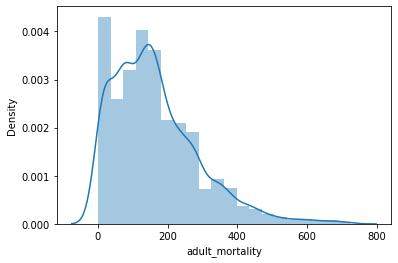

In [ ]:
# Check if variables to be analized are continous 
ax = sns.distplot(df_d['adult_mortality'], bins=20)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


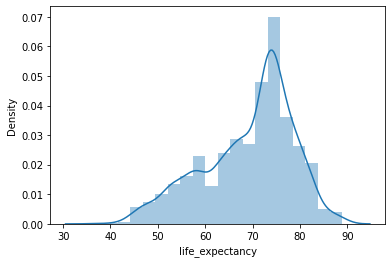

In [ ]:
ax = sns.distplot(df_d['life_expectancy'], bins=20)

In [ ]:
# Creat year groups by splitting the year values in to three groups each consisting five years
df_d['year_group'] = pd.cut(x=df_d['year'], bins=[2005, 2010, 2015], labels=['2006-2010', '2011-2015'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


This study focuses on data from developing countries recorded for the years after 2006 (inclusive). Thus, we will take that portion of data.

In [ ]:
# Create a new data frame named df_new that holds th portion of data
df_new=df_d["year_group"].isin(["2006-2010", "2011-2015"])&(df_d['status']=='Developing')
df_d=df_d.iloc[df_new.values]
df_d.shape

(1510, 23)

In [ ]:
# Check the records after selecting portion of data
df_d.shape

In [ ]:
# Number of unique countries in the new dataset
df_d['country'].value_counts()

In [ ]:
df_d.describe()

In [ ]:
# Divde data in to two groups Take only the data 2011 to 2015 
df_06_10 = df_d[(df_d['year_group'] == '2006-2010')]
df_11_15 = df_d[(df_d['year_group'] == '2011-2015')]

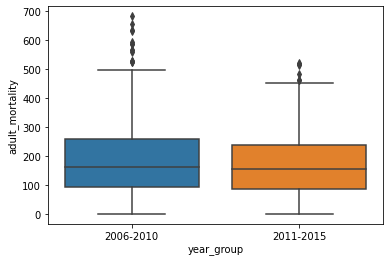

In [ ]:
# Plot a box plot to see if there are ouliers in adult_mortality for the two groups
sns.boxplot(x="year_group", y="adult_mortality", data=df_06_10)
sns.boxplot(x="year_group", y="adult_mortality", data=df_11_15)
plt.show()

Compared with life expectancy adult mortality seems to have more outliers. Various statistical assumptions and analysis results are sensitive to outliers. However, as much as we would like to, we cannot simply drop a value/observation because it is an outlier. In the real case scenario, it is important to investigate the real nature of the outlier before dropping them as outliers, sometimes, may unfold interesting and legitimate observations as well. Thus, in this study outliers are kept int he analysis.

In [ ]:
# Plot a box plot to see if there are ouliers in life_expectancy for the two groups
sns.boxplot(x="year_group", y="life_expectancy", data=df_06_10)
sns.boxplot(x="year_group", y="life_expectancy", data=df_11_15)
plt.show()

In [ ]:
# calculate the correlation matrix
corr = df_d.corr()

# plot the heatmap
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)


Coorelation between Adult Mortality and Life Expectancy

Even if there are many variables that affect Adult mortality and Life expectancy, in this study only these two variables are considered in this analysis as they are strongly negatively correlated as seen in the correlation and scatter plot. But, the same approach can be followed to test differences in the other variables over a given period. 

In [ ]:
# Calculate correlation between adult mortality and life expectancy
df_06_10['adult_mortality'].corr(df_06_10['life_expectancy'])

In [ ]:
#Plot scatter plot to see the corelation between adult mortality and life expectancy
plt.scatter(df_06_10['adult_mortality'], df_06_10['life_expectancy'])
plt.scatter(df_11_15['adult_mortality'], df_11_15['life_expectancy'])

plt.title('Adult mortality vs Life expectancy')
plt.xlabel('adult_mortality')
plt.ylabel('life_expectancy')

plt.show()

A paired test will be used to compare the two dependent "paired" groups. The difference score is calculated by subtracting each pair of scores and then calculating the mean difference, rather than calculating the difference of the means.

In [ ]:
# Plot a box plot to see if there are ouliers in life_expectancy
sns.boxplot(x="year_group", y="diff_cle", data=df_06_10)
sns.boxplot(x="year_group", y="life_expectancy", data=df_11_15)
plt.show()

Our null hypothesis for the paired t-test is that the mean difference between the two groups year categories is equal to zero.
The paired t-test assumes normality on the values.  The difference score is calculated by subtracting each pair of scores and then calculating the mean difference. Then, we will be testing the normality of the differences.


In [ ]:
# diff_am is the difference of each values in the two groups for the variable adult_mortality
diff_am=df_11_15['adult_mortality'].values-df_06_10['adult_mortality'].values

# diff_le is the difference of each values in the two groups for the variable life expectancy
diff_le=df_11_15['life_expectancy'].values-df_06_10['life_expectancy'].values

Test of normality  will be employed in order to decide if a parametric or non-parametric test to be used. There are different approaches can be used such as QQ plots and histograms.

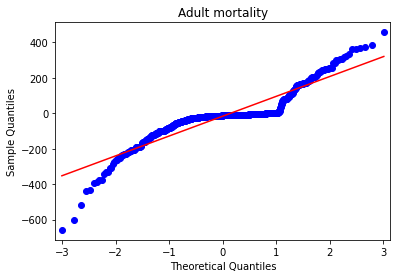

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


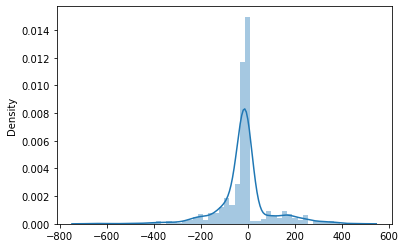

In [ ]:
# Test normality using visual examination - QQ plot and histogram for the difference of 'adult mortality'
qqplot(diff_am, line='s')
plt.title('Adult mortality')
plt.show()
sns.distplot(diff_am)


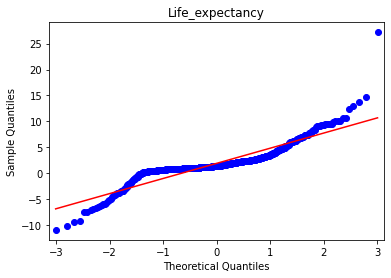

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


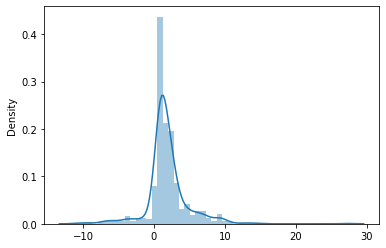

In [ ]:
# Test normality using visual examination - QQ plot and histogram for the difference of 'life_expectancy'

qqplot(diff_le, line='s')
plt.title('Life_expectancy')
plt.show()
sns.distplot(diff_le)


As seen in the above visual illustrations (QQ plots and histogram), life expectancy adult mortality can be assumed to have a normal distribution even if we don't get the perfect bell-shaped curve. As stated in the Central Limit Theorem, with large enough sizes, samples are often well-approximated by a normal distribution. Thus, this study will assume a paired ttest from scipy.stats to perform well on the given data. However, adult normality deviates from normality which requires the need of non-parametric test.
 

The null and alternative hypothisis are:

H0: µ1 = µ2  (their is no difference in the average life expectancy and age mortality for the years 2006-2010 and 2011- 2015 in developing countries.

H1: µ1 ≠ µ2 (there is no difference between the two groups

In [ ]:
t,p=stats.ttest_rel( df_11_15['life_expectancy'],df_06_10['life_expectancy'])
print (t,p)
if (p <0.05):
    print("pvalue < 0.05")

17.49324696730383 9.079528215558704e-58
pvalue < 0.05


The p-value is extremely small, implying the findings are significant and that there is a real difference. In other words, it tells that life expectancy changed between 2006-2010 and 2011-2015.

In [ ]:
# Test 
t,p=stats.ttest_rel( df_11_15['adult_mortality'],df_06_10['adult_mortality'])
print (t,p)
if (p <0.05):
    print("pvalue < 0.05")

In [ ]:
# Test 
t,p=stats.ttest_rel( df_11_15['life_expectancy'],df_06_10['life_expectancy'])
print (t,p)
if (p <0.05):
    print("pvalue < 0.05")

NameError: ignored

In [ ]:
# diff_am is the difference of each values in the two groups for the variable adult_mortality
diff_am=df_11_15['adult_mortality'].values-df_06_10['adult_mortality'].values


In [ ]:
 _, p=stats.wilcoxon((df_11_15['adult_mortality'].values-df_06_10['adult_mortality'].values))
if (p <0.05):
    print("pvalue < 0.05")

pvalue < 0.05


Going by the p-value, the findings are significant. The difference in means is significantly different than zero.

In [ ]:
df_d['status'].value_counts()

In [ ]:
# Calculate the 95% confidence interval for life_expectancy
get_95_ci_p(df_11_15['life_expectancy'],df_06_10['life_expectancy'])

According to a 95% CI, we can quantify the difference between 2006-2010 and 2011-2015 as likely being between 1.0 & 2.7. In other words, countries life expectancy has increased by 1.0 to 2.7 more years in 2011-2015 than it was in 2006-2010. 

In [ ]:
# Calculate the 95% confidence interval for adult_mortality
get_95_ci_p(df_11_15['adult_mortality'],df_06_10['adult_mortality'])

We are 95% confident that the difference in mean adult mortality between the two year groups, 2006-2010 & 2011-2015, is between -27.9 and -4.3. It can also be explained as, adult mortality has declined by 27 to 4 years in 2011-2015 than it was in 2006-2010.


In [ ]:
Conclusion

In this study we have seen a significant difference between adult mortality and life expectancy between the two groups, namely 2006-2010 and 2011-2015. As seen int the correlation, we have seen a result that supports the theory that adult mortality is inversely proportional to life expectancy. During the given years, it is seen that increased life expectancy and decreased mortality rate. However, this trend should be thoroughly studied especially in the presence of  situations like Pandemics (Spanish flue and Covid 19 are good examples), where statistical results may not tell the expected trend.

This analysis can be used as a starting point to perform various follow up research ideas. Life expectancy can be influenced by many variables (as seen in the correlation matrix) including, income, child mortality, infant mortality, income, schooling and other variables like HIV/AIDs. Thus, further studies need to be done to see the entire picture of factors affecting life expectancy. In addition, different research documents, including those by CDC and United Nations, reported life expectancy and adult mortality are affected by gender and age, which this dataset hasn’t incorporated and need to include in the future.

Research projects like this can be used by different stake holders. Policy makers and medical researchers can benefit from it as public health intervention, good health care plans and fund allocations can play a significant role in making informed decision and improving the overall health of a society. Educators and community leaders can play an important role by educating the community about the risk of alcohol and drug use, which directly affects adult mortality. Finally, such studies will highly benefit local and international development monitoring including Sustainable Development Goals (SDGs) in order to assess the social and economic development of a region or country.
